# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import re
%matplotlib inline
import matplotlib.pyplot as plt
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sqlalchemy import create_engine

[nltk_data] Downloading package punkt to /Users/takahiro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/takahiro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/takahiro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# load data from database
engine = create_engine('sqlite:///InsertDatabaseName.db')
df = pd.read_sql_table('InsertTableName', con=engine)

categories = df.columns[4:]

X = df[['message']].values[:, 0]
y = df[categories].values

### 2. Write a tokenization function to process your text data

In [3]:
url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

def tokenize(text, lemmatizer=WordNetLemmatizer()):
    # Detecte URLs
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, 'urlplaceholder')
    
    # Normalize and tokenize
    tokens = nltk.word_tokenize(re.sub(r"[^a-zA-Z0-9]", " ", text.lower()))
    
    # Remove stopwords
    tokens = [t for t in tokens if t not in stopwords.words('english')]

    # Lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    
    return tokens

In [4]:
# Check vocabulary
vect = CountVectorizer(tokenizer=tokenize)
X_vectorized = vect.fit_transform(X)

In [5]:
# Convert vocabulary into pandas.dataframe
keys, values = [], []
for k, v in vect.vocabulary_.items():
    keys.append(k)
    values.append(v)

vocabulary = pd.DataFrame.from_dict({'words': keys, 'counts': values})

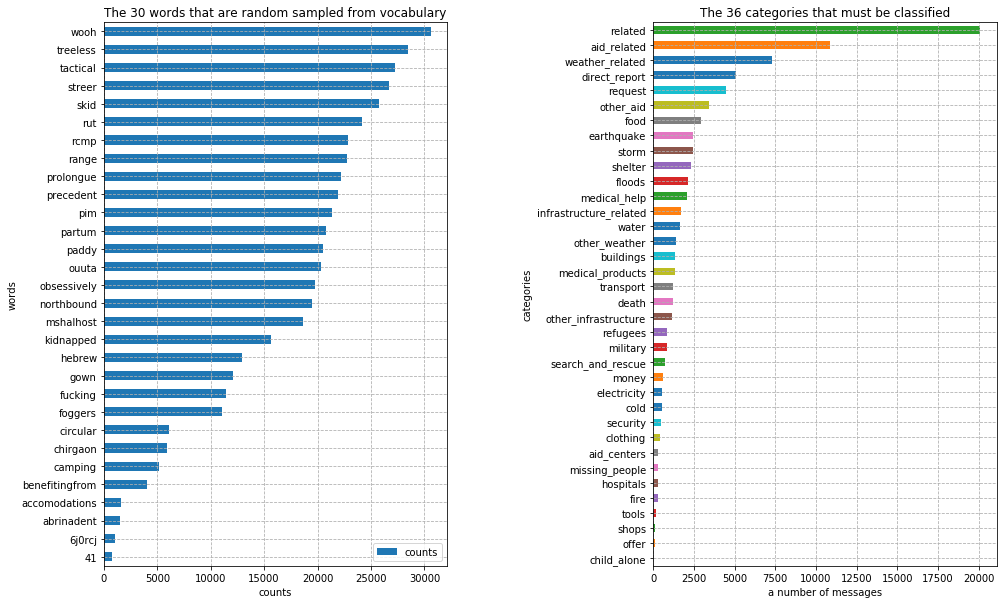

In [7]:
plt.figure(figsize=(16, 10))
plt.subplots_adjust(wspace=0.6)

ax1 = plt.subplot(1, 2, 1)
vocabulary.sample(30, random_state=72).sort_values('counts').plot.barh(x='words', y='counts', ax=ax1, colormap='tab10')
plt.title('The 30 words that are random sampled from vocabulary')
plt.xlabel('counts')
plt.grid(linestyle='dashed')

ax2 = plt.subplot(1, 2, 2)
df[categories].sum().sort_values().plot.barh(ax=ax2)
plt.title('The 36 categories that must be classified')
plt.ylabel('categories')
plt.xlabel('a number of messages')
plt.grid(linestyle='dashed')

plt.show()

### 3. Build a machine learning pipeline
- You'll find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [4]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier(class_weight='balanced')))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [6]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...oob_score=False, random_state=None,
            verbose=0, warm_start=False),
           n_jobs=1))])

### 5. Test your model
Report the f1 score, precision and recall on both the training set and the test set. You can use sklearn's `classification_report` function here. 

In [7]:
def multioutput_classification_report(y_true, y_pred):
    for i in range(0, len(categories)):
        print(categories[i])
        print("\tAccuracy: {:.4f}\t\t% Precision: {:.4f}\t\t% Recall: {:.4f}\t\t% F1_score: {:.4f}".format(
            accuracy_score(y_true[:, i], y_pred[:, i]),
            precision_score(y_true[:, i], y_pred[:, i], average='weighted'),
            recall_score(y_true[:, i], y_pred[:, i], average='weighted'),
            f1_score(y_true[:, i], y_pred[:, i], average='weighted')
        ))
        #print(classification_report(y_true[:, i], y_pred[:, i]))
        #print("--------------------------------------------------")

In [8]:
y_pred = pipeline.predict(X_train)

In [9]:
multioutput_classification_report(y_train, y_pred)

related
	Accuracy: 0.9905		% Precision: 0.9905		% Recall: 0.9905		% F1_score: 0.9905
request
	Accuracy: 0.9889		% Precision: 0.9890		% Recall: 0.9889		% F1_score: 0.9888
offer
	Accuracy: 0.9987		% Precision: 0.9987		% Recall: 0.9987		% F1_score: 0.9986
aid_related
	Accuracy: 0.9869		% Precision: 0.9870		% Recall: 0.9869		% F1_score: 0.9869
medical_help
	Accuracy: 0.9883		% Precision: 0.9884		% Recall: 0.9883		% F1_score: 0.9879
medical_products
	Accuracy: 0.9925		% Precision: 0.9925		% Recall: 0.9925		% F1_score: 0.9922
search_and_rescue
	Accuracy: 0.9931		% Precision: 0.9932		% Recall: 0.9931		% F1_score: 0.9927
security
	Accuracy: 0.9943		% Precision: 0.9943		% Recall: 0.9943		% F1_score: 0.9938
military
	Accuracy: 0.9958		% Precision: 0.9958		% Recall: 0.9958		% F1_score: 0.9957
child_alone
	Accuracy: 1.0000		% Precision: 1.0000		% Recall: 1.0000		% F1_score: 1.0000
water
	Accuracy: 0.9945		% Precision: 0.9945		% Recall: 0.9945		% F1_score: 0.9943
food
	Accuracy: 0.9946		% Precision

In [10]:
y_pred = pipeline.predict(X_test)

In [11]:
multioutput_classification_report(y_test, y_pred)

related
	Accuracy: 0.8116		% Precision: 0.8004		% Recall: 0.8116		% F1_score: 0.8038
request
	Accuracy: 0.8819		% Precision: 0.8717		% Recall: 0.8819		% F1_score: 0.8706
offer
	Accuracy: 0.9960		% Precision: 0.9921		% Recall: 0.9960		% F1_score: 0.9941
aid_related
	Accuracy: 0.7469		% Precision: 0.7466		% Recall: 0.7469		% F1_score: 0.7417
medical_help
	Accuracy: 0.9246		% Precision: 0.9002		% Recall: 0.9246		% F1_score: 0.8968
medical_products
	Accuracy: 0.9498		% Precision: 0.9336		% Recall: 0.9498		% F1_score: 0.9285
search_and_rescue
	Accuracy: 0.9756		% Precision: 0.9641		% Recall: 0.9756		% F1_score: 0.9638
security
	Accuracy: 0.9838		% Precision: 0.9688		% Recall: 0.9838		% F1_score: 0.9763
military
	Accuracy: 0.9695		% Precision: 0.9583		% Recall: 0.9695		% F1_score: 0.9575
child_alone
	Accuracy: 1.0000		% Precision: 1.0000		% Recall: 1.0000		% F1_score: 1.0000
water
	Accuracy: 0.9512		% Precision: 0.9472		% Recall: 0.9512		% F1_score: 0.9378
food
	Accuracy: 0.9291		% Precision

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 6. Improve your model
Use grid search to find better parameters. 

In [12]:
parameters = {
    'clf__estimator__n_estimators': [20, 50]
}

cv = GridSearchCV(estimator=pipeline, param_grid=parameters, cv=3, scoring='f1_weighted', verbose=3)

In [13]:
cv.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] clf__estimator__n_estimators=20 .................................


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__n_estimators=20, score=0.5462536138753139, total= 3.5min
[CV] clf__estimator__n_estimators=20 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.8min remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__n_estimators=20, score=0.5287765354169653, total= 3.5min
[CV] clf__estimator__n_estimators=20 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.6min remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__n_estimators=20, score=0.5421465294975419, total= 3.5min
[CV] clf__estimator__n_estimators=50 .................................


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__n_estimators=50, score=0.5541616312663988, total= 6.1min
[CV] clf__estimator__n_estimators=50 .................................


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__n_estimators=50, score=0.5420472461086017, total= 6.0min
[CV] clf__estimator__n_estimators=50 .................................


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__n_estimators=50, score=0.5464319248841025, total= 6.1min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 36.6min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...oob_score=False, random_state=None,
            verbose=0, warm_start=False),
           n_jobs=1))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__estimator__n_estimators': [20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=3)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.

In [14]:
y_pred = cv.predict(X_train)

In [15]:
multioutput_classification_report(y_train, y_pred)

related
	Accuracy: 0.9980		% Precision: 0.9980		% Recall: 0.9980		% F1_score: 0.9980
request
	Accuracy: 0.9990		% Precision: 0.9990		% Recall: 0.9990		% F1_score: 0.9990
offer
	Accuracy: 0.9999		% Precision: 0.9999		% Recall: 0.9999		% F1_score: 0.9999
aid_related
	Accuracy: 0.9990		% Precision: 0.9990		% Recall: 0.9990		% F1_score: 0.9990
medical_help
	Accuracy: 0.9989		% Precision: 0.9989		% Recall: 0.9989		% F1_score: 0.9989
medical_products
	Accuracy: 0.9993		% Precision: 0.9993		% Recall: 0.9993		% F1_score: 0.9993
search_and_rescue
	Accuracy: 0.9996		% Precision: 0.9996		% Recall: 0.9996		% F1_score: 0.9996
security
	Accuracy: 0.9995		% Precision: 0.9995		% Recall: 0.9995		% F1_score: 0.9995
military
	Accuracy: 0.9993		% Precision: 0.9993		% Recall: 0.9993		% F1_score: 0.9993
child_alone
	Accuracy: 1.0000		% Precision: 1.0000		% Recall: 1.0000		% F1_score: 1.0000
water
	Accuracy: 0.9999		% Precision: 0.9999		% Recall: 0.9999		% F1_score: 0.9999
food
	Accuracy: 0.9997		% Precision

In [16]:
y_pred = cv.predict(X_test)

In [17]:
multioutput_classification_report(y_test, y_pred)

related
	Accuracy: 0.8251		% Precision: 0.8124		% Recall: 0.8251		% F1_score: 0.8127
request
	Accuracy: 0.8993		% Precision: 0.8931		% Recall: 0.8993		% F1_score: 0.8907
offer
	Accuracy: 0.9960		% Precision: 0.9921		% Recall: 0.9960		% F1_score: 0.9941
aid_related
	Accuracy: 0.7731		% Precision: 0.7720		% Recall: 0.7731		% F1_score: 0.7722
medical_help
	Accuracy: 0.9268		% Precision: 0.9143		% Recall: 0.9268		% F1_score: 0.8974
medical_products
	Accuracy: 0.9515		% Precision: 0.9422		% Recall: 0.9515		% F1_score: 0.9320
search_and_rescue
	Accuracy: 0.9765		% Precision: 0.9741		% Recall: 0.9765		% F1_score: 0.9660
security
	Accuracy: 0.9840		% Precision: 0.9688		% Recall: 0.9840		% F1_score: 0.9763
military
	Accuracy: 0.9693		% Precision: 0.9576		% Recall: 0.9693		% F1_score: 0.9567
child_alone
	Accuracy: 1.0000		% Precision: 1.0000		% Recall: 1.0000		% F1_score: 1.0000
water
	Accuracy: 0.9536		% Precision: 0.9482		% Recall: 0.9536		% F1_score: 0.9436
food
	Accuracy: 0.9355		% Precision

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [18]:
pipeline_ada = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(
        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced'))
    ))
])

parameters_ada = {
    'clf__estimator__learning_rate': [0.1, 0.3],
    'clf__estimator__n_estimators': [100, 200]
}

cv_ada = GridSearchCV(estimator=pipeline_ada, param_grid=parameters_ada, cv=3, scoring='f1_weighted', verbose=3)

In [19]:
cv_ada.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=100 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=100, score=0.6098824513314661, total= 3.8min
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.2min remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=100, score=0.610312616114416, total= 3.9min
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 10.4min remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=100, score=0.6057716691033361, total= 3.9min
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200, score=0.6243810943839812, total= 6.0min
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200, score=0.6227103514158638, total= 5.9min
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200, score=0.6183475026450643, total= 5.9min
[CV] clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=100 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=100, score=0.6269425922665877, total= 3.8min
[CV] clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=100 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=100, score=0.6310619675454391, total= 3.8min
[CV] clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=100 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=100, score=0.6214506356996695, total= 4.0min
[CV] clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=200 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=200, score=0.6357695325794616, total= 6.9min
[CV] clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=200 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=200, score=0.6362822047827656, total= 7.0min
[CV] clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=200 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=200, score=0.6328597361770263, total= 7.0min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 79.3min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...er='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
           n_jobs=1))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__estimator__learning_rate': [0.1, 0.3], 'clf__estimator__n_estimators': [100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=3)

In [20]:
# Best parameters set
cv_ada.best_params_

{'clf__estimator__learning_rate': 0.3, 'clf__estimator__n_estimators': 200}

In [21]:
y_pred = cv_ada.predict(X_train)

In [22]:
multioutput_classification_report(y_train, y_pred)

related
	Accuracy: 0.7390		% Precision: 0.8370		% Recall: 0.7390		% F1_score: 0.7586
request
	Accuracy: 0.8689		% Precision: 0.8884		% Recall: 0.8689		% F1_score: 0.8756
offer
	Accuracy: 0.9612		% Precision: 0.9958		% Recall: 0.9612		% F1_score: 0.9765
aid_related
	Accuracy: 0.7849		% Precision: 0.7837		% Recall: 0.7849		% F1_score: 0.7839
medical_help
	Accuracy: 0.8930		% Precision: 0.9281		% Recall: 0.8930		% F1_score: 0.9060
medical_products
	Accuracy: 0.9013		% Precision: 0.9541		% Recall: 0.9013		% F1_score: 0.9208
search_and_rescue
	Accuracy: 0.8742		% Precision: 0.9699		% Recall: 0.8742		% F1_score: 0.9122
security
	Accuracy: 0.8787		% Precision: 0.9806		% Recall: 0.8787		% F1_score: 0.9208
military
	Accuracy: 0.9611		% Precision: 0.9779		% Recall: 0.9611		% F1_score: 0.9670
child_alone
	Accuracy: 1.0000		% Precision: 1.0000		% Recall: 1.0000		% F1_score: 1.0000
water
	Accuracy: 0.9495		% Precision: 0.9656		% Recall: 0.9495		% F1_score: 0.9547
food
	Accuracy: 0.9522		% Precision

In [23]:
y_pred = cv_ada.predict(X_test)

In [24]:
multioutput_classification_report(y_test, y_pred)

related
	Accuracy: 0.7231		% Precision: 0.8232		% Recall: 0.7231		% F1_score: 0.7443
request
	Accuracy: 0.8488		% Precision: 0.8755		% Recall: 0.8488		% F1_score: 0.8580
offer
	Accuracy: 0.9529		% Precision: 0.9931		% Recall: 0.9529		% F1_score: 0.9721
aid_related
	Accuracy: 0.7678		% Precision: 0.7665		% Recall: 0.7678		% F1_score: 0.7667
medical_help
	Accuracy: 0.8897		% Precision: 0.9244		% Recall: 0.8897		% F1_score: 0.9031
medical_products
	Accuracy: 0.8941		% Precision: 0.9422		% Recall: 0.8941		% F1_score: 0.9133
search_and_rescue
	Accuracy: 0.8489		% Precision: 0.9643		% Recall: 0.8489		% F1_score: 0.8983
security
	Accuracy: 0.8422		% Precision: 0.9730		% Recall: 0.8422		% F1_score: 0.9005
military
	Accuracy: 0.9507		% Precision: 0.9719		% Recall: 0.9507		% F1_score: 0.9589
child_alone
	Accuracy: 1.0000		% Precision: 1.0000		% Recall: 1.0000		% F1_score: 1.0000
water
	Accuracy: 0.9471		% Precision: 0.9636		% Recall: 0.9471		% F1_score: 0.9527
food
	Accuracy: 0.9487		% Precision

### 9. Export your model as a pickle file

In [25]:
with open('adaboost_cv.pkl', 'wb') as file:
    pickle.dump(cv_ada, file)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.